###  Autor: Lilian Rebeca Carrera Lemus 
No. Carnet: 20008077  


# Práctica No. 1: K-means y Detección de Anomalías

### Parte 1: Clustering

* Utilizar los datos del archivo estaturas (primera pestaña) para implementar:
    * Hard-clustering con k-means (no usar sklearn)
    * Soft-clustering con GMM usando sklearn
* Ejecutar al menos 5 experimentos para seleccionar el valor de “K”
    * Ambos métodos pueden usar el mismo valor de “K”
    * Analizar el centroide de cada clúster y determinar si es posible asignar una categoría  cada clúster
* Analizar y concluir si el método del codo es adecuado para este problema
* Usar los datos en la segunda pestaña y estimar:
    * El clúster que k-means asigna cada uno.
    * La probabilidad de pertenecer a cada clúster según GMM


In [101]:
#Librerías a utilizar
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
#Cargamos los datos a utilizar del archivo de Excel
data_train = pd.read_excel('estaturas.xlsx', sheet_name='normales')
data_test = pd.read_excel('estaturas.xlsx', sheet_name='valtest(normales)')
data_anomalias = pd.read_excel('estaturas.xlsx', sheet_name='anomalias')
data_train.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


### Implementación de Hard-clustering con k-means (no usar sklearn)

In [94]:
# Funcion para obtener los valores aleatorios
#Para generar los número aleatorios los convertimos a entero para que sea más fácil trabajar con numpy
def valores_random(minimo,maximo):
    valor_random = np.random.randint(1,100)
    valor = (maximo-minimo)/100
    posicion = valor * valor_random
    resultado = float(minimo + posicion)
    return resultado

In [95]:
#Función para asignar una observación de los datos a un cluster mediante el cálculo de la distancia menor respecto del centroide
def asignacion(data, centroides, colores):
        for i in centroides.keys():
            data['distancia_desde_{}'.format(i)] = (np.sqrt((data['Estatura(metros)'] - centroides[i][0])**2 + (data['Edad(años)'] - centroides[i][1])**2 ))
            
        distancia_centroides = ['distancia_desde_{}'.format(i) for i in centroides.keys()]
        data['distancia_menor'] = data.loc[:, distancia_centroides].idxmin(axis=1)
        data['distancia_menor'] = data['distancia_menor'].map(lambda x: int(x.lstrip('distancia_desde_')))
        data['color'] = data['distancia_menor'].map(lambda x: colores[x])
        return data

In [96]:
#Función para implementar k-means 
def k_means(k, data, semilla):
    #Estableceremos una semilla aleatoria para tener los mismos resultados
    np.random.seed(semilla)
    centroides = dict() #Diccionario para almacenar los centroides
    
    #Calculo de máximos y minimos para inicializar los centroides
    est_min = np.min(data_train['Estatura(metros)'])
    est_max= np.max(data_train['Estatura(metros)'])
    edad_min = np.min(data_train['Edad(años)'])
    edad_max= np.min(data_train['Edad(años)'])
    
    #Inicialización aleatoria de centroides
    for i in range(k):
        centroides[i+1]= [valores_random(est_min, est_max), valores_random(edad_min, edad_max)]
        
    colores = {1: 'blue', 2: 'green', 3: 'red', 4: 'orange', 5: 'purple', 6: 'pink'}
    
    # 1.Asignación de cluster
    data = asignacion(data, centroides, colores)

    # Copia de los centroides anteriores
    centroides_ant = copy.deepcopy(centroides)

    #Función para actualizar la ubicación de centroides
    def actualizar_centroides(k):
        for i in centroides.keys():
            centroides[i][0] = np.mean(data[data['distancia_menor'] == i]['Estatura(metros)'])
            centroides[i][1] = np.mean(data[data['distancia_menor'] == i]['Edad(años)'])
        return k

    #2.Reubicación de centroides
    centroides = actualizar_centroides(centroides)
    
    # Repetir hasta que ya no cambie 
    while True:
        centroides_cercanos = data['distancia_menor'].copy(deep=True)
        centroides = actualizar_centroides(centroides)
        data = asignacion(data, centroides, colores)
        if centroides_cercanos.equals(data['distancia_menor']):
            break
    
    #Calculo de la función de costo, función de distorsiónn
    suma_cuadrados = []
    for i in range(k):
        distancia_obj = data[data.distancia_menor==i+1]
        cuadrados=distancia_obj['distancia_desde_'+str(i+1)].pow(2)
        suma_cuadrados.append(cuadrados.sum())
        
    #Costo
    distorsion = np.sum(suma_cuadrados)
    
    return data, centroides, colores, distorsion

In [97]:
#Funcion para graficar el modelo
def graficar_k_means(data, centroides, colores):
    #Graficamos los resultado
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(data['Estatura(metros)'], data['Edad(años)'], color=data['color'], alpha=0.5, edgecolor = 'k')
    for i in centroides.keys():
        plt.scatter(*centroides[i], color='black')
    plt.xlim(1.40, 2.10)
    plt.ylim(15, 45)
    plt.title('K-means con K='+str(i))
    plt.xlabel('Estatura(metros)')
    plt.ylabel('Edad(años)')
    plt.show()

#### Experimentos para seleccionar k

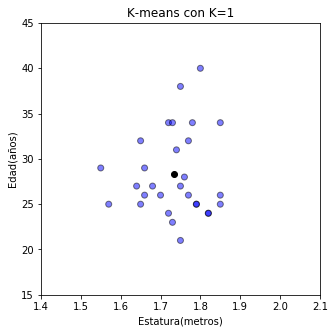

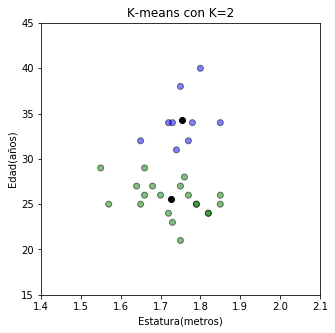

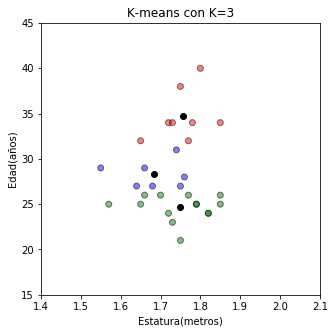

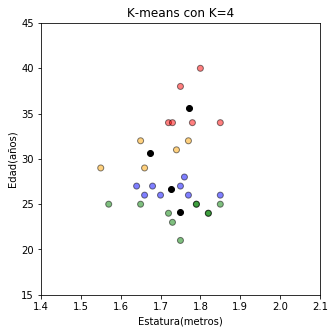

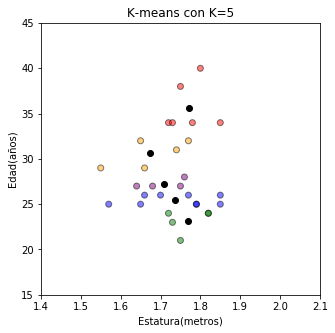

In [98]:
lista_error = []
for i in range(1,6):
    df_salida, centroides, colores, distorsion = k_means(i,data_train, 140)
    lista_error.append(distorsion)
    graficar_k_means(df_salida, centroides, colores)

Se ralizaron 6 experimientos para seleccionar el número de k, sin embargo como elegir el mejor.

### Método del Codo  

La idea básica de los algoritmos de clustering es la minimización de la varianza intra-cluster y la maximización de la varianza inter-cluster. Es decir, queremos que cada observación se encuentre muy cerca a las de su mismo grupo y los grupos lo más lejos posible entre ellos.

El método del codo utiliza la distancia media de las observaciones a su centroide. Es decir, se fija en las distancias intra-cluster. Cuanto más grande es el número de clusters k, la varianza intra-cluster tiende a disminuir. Cuanto menor es la distancia intra-cluster mejor, ya que significa que los clústers son más compactos. El método del codo busca el valor k que satisfaga que un incremento de k, no mejore sustancialmente la distancia media intra-cluster.

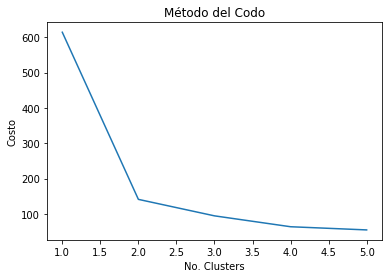

In [113]:
#Implementación Método del codo para el algoritmo generado de k-means
plt.plot(range(1, 6), lista_error)
plt.title('Método del Codo')
plt.xlabel('No. Clusters')
plt.ylabel('Costo')
plt.show()

El la gráfica se observa que la suma de las distancias disminuye conforme aumenta el número de clusters y esa disminución se va atenuando conforme aumentan los número de clusters. El punto en donde se hace un codo y el cambio en el valor de la suma de las distancias se reduce significativamente, es el valor que nos indica el número óptimo de clusters que deberá tener la muestra. En este caso el punto óptimo es 3

### Implementación de Soft-clustering con GMM usando sklearn

In [104]:
data_train=pd.DataFrame(data_train, columns =["Estatura(metros)","Edad(años)"])
data_train.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


In [109]:
#Entrenamos el modelo utilizando el mismo k de acuerdo al método del codo
modelo_gm = GaussianMixture(n_components = 4).fit(data_train)
etiquetas = modelo_gm.predict(data_train)

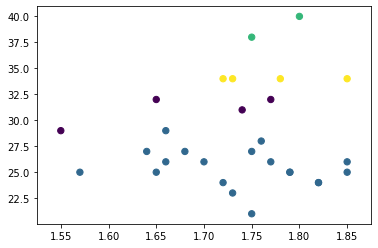

In [110]:
#Visualizamos los clusters generados
plt.scatter(data_train["Estatura(metros)"],data_train["Edad(años)"], c = etiquetas, s = 40, cmap = 'viridis')